In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = "/content/drive/MyDrive/5334_Assignment1/images/train"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/drive/MyDrive/5334_Assignment1/images/train


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28821


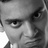

In [ ]:
angry = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry[0]))

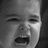

In [ ]:
PIL.Image.open(str(angry[1]))

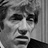

In [ ]:
disgust = list(data_dir.glob('disgust/*'))
PIL.Image.open(str(disgust[0]))

In [ ]:
batch_size = 32
img_height = 48
img_width = 48

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 28821 files belonging to 7 classes.
Using 5764 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


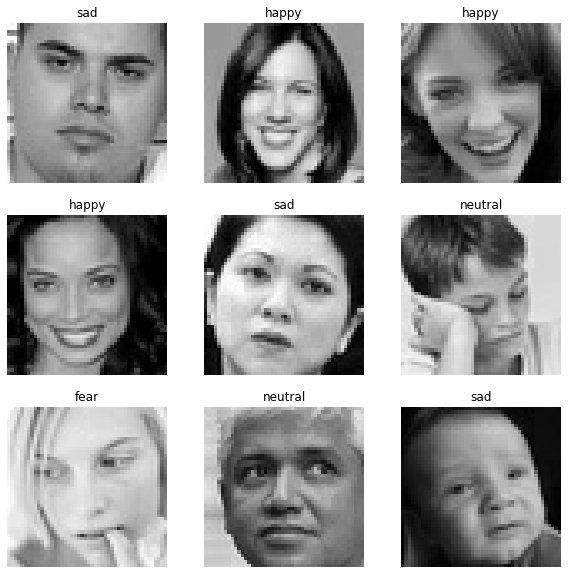

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9921569


Model 1: Basic Image Classifier Model using TensorFlow tutorial

In [ ]:
# code taken from [2], adapted slightly for performance reasons on larger dataset.
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
721/721 [==============================] - 98s 102ms/step - loss: 1.6541 - accuracy: 0.3416 - val_loss: 1.4840 - val_accuracy: 0.4388
Epoch 2/5
721/721 [==============================] - 73s 101ms/step - loss: 1.4010 - accuracy: 0.4641 - val_loss: 1.3738 - val_accuracy: 0.4738
Epoch 3/5
721/721 [==============================] - 66s 92ms/step - loss: 1.2729 - accuracy: 0.5150 - val_loss: 1.3157 - val_accuracy: 0.4950
Epoch 4/5
721/721 [==============================] - 70s 97ms/step - loss: 1.1786 - accuracy: 0.5532 - val_loss: 1.2819 - val_accuracy: 0.5224
Epoch 5/5
721/721 [==============================] - 69s 95ms/step - loss: 1.0902 - accuracy: 0.5901 - val_loss: 1.2516 - val_accuracy: 0.5281


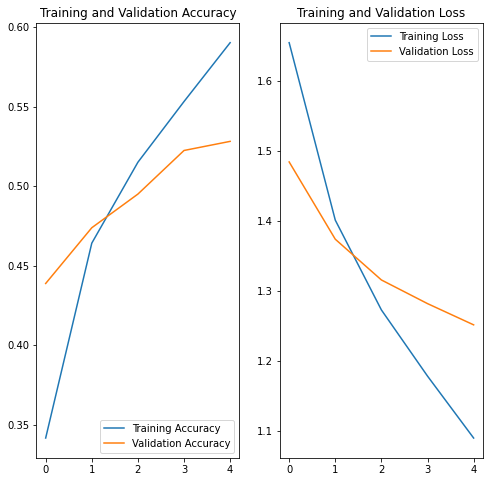

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2

In [ ]:
# code taken from [12], adapted slightly for performance reasons on larger dataset.

from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

num_classes = len(class_names)

model2 = Sequential([
    #First Convolutional layer and corresponding pooling layer
    layers.Conv2D(8, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    #Second Convolutional layer and corresponding pooling layer
    layers.Conv2D(16, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Third Convolutional layer and corresponding pooling layer
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Fourth Convolutional layer and corresponding pooling layer
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    
    #Fully connected layer and corresponding pooling layer
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model2.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 48, 48, 8)         608       
                                                                 
 batch_normalization_66 (Bat  (None, 48, 48, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 24, 24, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 24, 24, 16)        3216      
                                                                 
 batch_normalization_67 (Bat  (None, 24, 24, 16)       64        
 chNormalization)                                                
                                                     

In [ ]:
epochs=5
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


721/721 [==============================] - 97s 132ms/step - loss: 1.6194 - accuracy: 0.3611 - val_loss: 1.5475 - val_accuracy: 0.4087
Epoch 2/5
721/721 [==============================] - 96s 134ms/step - loss: 1.3701 - accuracy: 0.4694 - val_loss: 1.3787 - val_accuracy: 0.4813
Epoch 3/5
721/721 [==============================] - 94s 130ms/step - loss: 1.2298 - accuracy: 0.5298 - val_loss: 1.4475 - val_accuracy: 0.4589
Epoch 4/5
721/721 [==============================] - 96s 133ms/step - loss: 1.1088 - accuracy: 0.5796 - val_loss: 1.3190 - val_accuracy: 0.5144
Epoch 5/5
721/721 [==============================] - 94s 131ms/step - loss: 0.9846 - accuracy: 0.6337 - val_loss: 1.3588 - val_accuracy: 0.5173


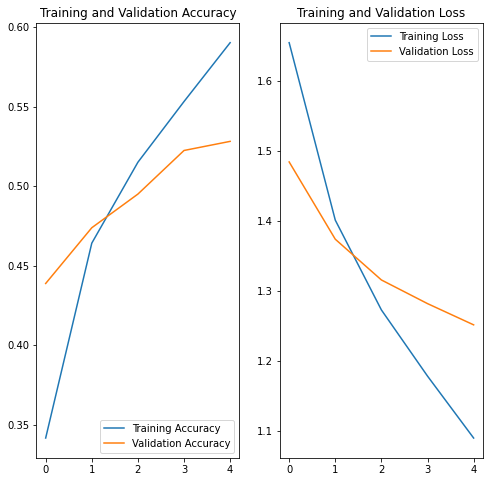

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 3

In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

num_classes = len(class_names)

model3 = Sequential([
    #First CNN layer
    layers.Conv2D(8, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    #Second CNN layer
    layers.Conv2D(16, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    #Third CNN layer
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    #Fourth CNN layer
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    #flattening before passing to FC layer
    layers.Flatten(),    
    #Fully connected layer
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    #Second Fully connected layer
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model3.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 8)         608       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 8)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 16)        3216      
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 16)      

In [ ]:
epochs=5
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


721/721 [==============================] - 124s 168ms/step - loss: 1.8861 - accuracy: 0.2402 - val_loss: 1.7191 - val_accuracy: 0.2923
Epoch 2/5
721/721 [==============================] - 111s 154ms/step - loss: 1.7171 - accuracy: 0.3133 - val_loss: 1.6029 - val_accuracy: 0.3810
Epoch 3/5
721/721 [==============================] - 116s 161ms/step - loss: 1.6051 - accuracy: 0.3701 - val_loss: 1.5065 - val_accuracy: 0.4226
Epoch 4/5
721/721 [==============================] - 115s 160ms/step - loss: 1.5427 - accuracy: 0.3996 - val_loss: 1.4624 - val_accuracy: 0.4499
Epoch 5/5
721/721 [==============================] - 115s 160ms/step - loss: 1.4812 - accuracy: 0.4280 - val_loss: 1.4158 - val_accuracy: 0.4589


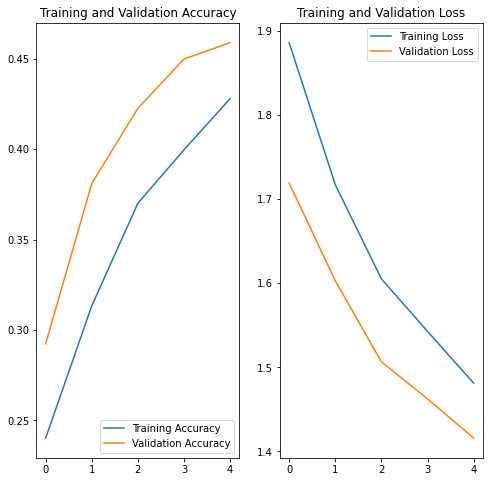

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Sources: 

[1] https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

[2] https://www.tensorflow.org/tutorials/images/classification

[3] https://en.wikipedia.org/wiki/Contextual_image_classification

[4] https://en.wikipedia.org/wiki/Statistical_classification

[5] https://medium.com/swlh/image-classification-using-machine-learning-and-deep-learning-2b18bfe4693f

[6] https://huggingface.co/tasks/image-classification

[7]https://www.researchgate.net/publication/332284670/figure/fig1/AS:745591005007874@1554774156651/Example-of-a-CNN-for-image-classification.ppm

[8] https://en.wikipedia.org/wiki/Convolutional_neural_network

[9] https://www.clarifai.com/blog/what-is-convolutional-networking?hs_amp=true&utm_term=&utm_campaign=DSA-Community&utm_source=adwords&utm_medium=ppc&hsa_acc=4305946045&hsa_cam=18142553015&hsa_grp=141361868638&hsa_ad=618056207992&hsa_src=g&hsa_tgt=dsa-19959388920&hsa_kw=&hsa_mt=&hsa_net=adwords&hsa_ver=3&gclid=CjwKCAjwzNOaBhAcEiwAD7Tb6Bd_39yY3s-xpiUj0Nx3y3GfmfnJGGP03tZWNNaBpQ-7AAZkujrVDBoCCAIQAvD_BwE

[10] https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/

[11] https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

[12] https://medium.com/@bolajkiran_89403/image-classification-cd7a2ed0223a

[13] https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9

[14] https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

[15] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
